Epoch 1/10
469/469 - 17s - 36ms/step - loss: 0.0362 - val_loss: 0.0108
Epoch 2/10
469/469 - 17s - 37ms/step - loss: 0.0083 - val_loss: 0.0063
Epoch 3/10
469/469 - 17s - 37ms/step - loss: 0.0059 - val_loss: 0.0051
Epoch 4/10
469/469 - 17s - 36ms/step - loss: 0.0049 - val_loss: 0.0044
Epoch 5/10
469/469 - 17s - 37ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 6/10
469/469 - 17s - 37ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 7/10
469/469 - 17s - 37ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 8/10
469/469 - 17s - 37ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 9/10
469/469 - 17s - 37ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 10/10
469/469 - 17s - 37ms/step - loss: 0.0031 - val_loss: 0.0031


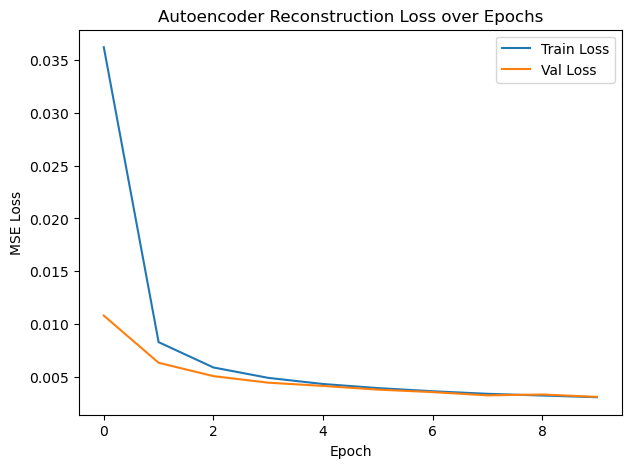

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


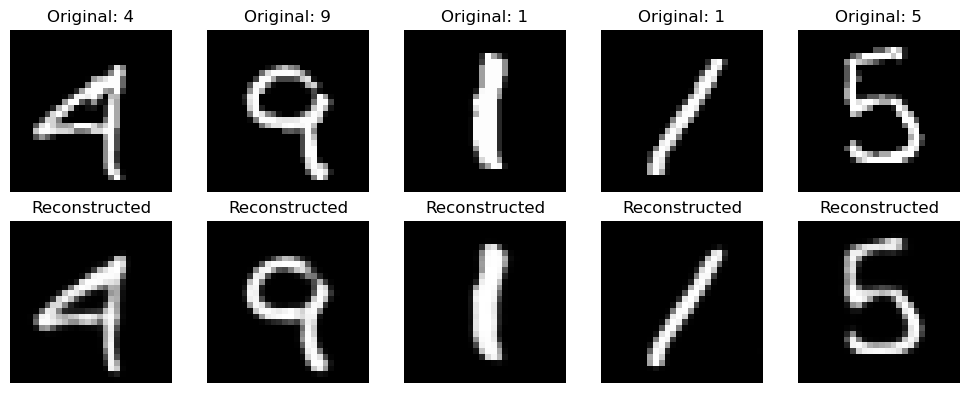

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/10
469/469 - 1s - 1ms/step - accuracy: 0.2441 - loss: 0.1856 - val_accuracy: 0.2827 - val_loss: 0.0767
Epoch 2/10
469/469 - 0s - 583us/step - accuracy: 0.2913 - loss: 0.0661 - val_accuracy: 0.3154 - val_loss: 0.0513
Epoch 3/10
469/469 - 0s - 583us/step - accuracy: 0.2898 - loss: 0.0495 - val_accuracy: 0.3038 - val_loss: 0.0441
Epoch 4/10
469/469 - 0s - 626us/step - accuracy: 0.2732 - loss: 0.0418 - val_accuracy: 0.2443 - val_loss: 0.0403
Epoch 5/10
469/469 - 0s - 575us/step - accuracy: 0.2647 - loss: 0.0360 - val_accuracy: 0.2838 - val_loss: 0.0373
Epoch 6/10
469/469 - 0s - 590us/step - accuracy: 0.2818 - loss: 0.0325 - val_accuracy: 0.3054 - val_loss: 0.0311
Epoch 7/10
469/469 - 0s - 642us/step - accuracy: 0.2693 - loss: 0.0296 - val_accuracy: 0.3014 - val_loss: 0.0302
Epoch 8/10
469/469 - 0s - 560us/step - accuracy: 0.2797 - loss: 0.0270 - val_accuracy: 0.2006 - val_loss: 0.0300
Epoch 9/10
469

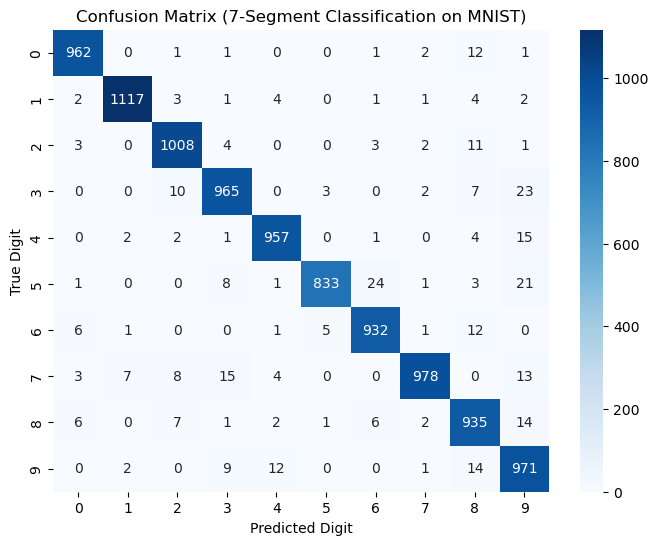

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# ----------------------------------------------------------
# 1. Load the MNIST dataset and preprocess
# ----------------------------------------------------------
def load_and_preprocess_mnist():
    (mnist_train_x, mnist_train_y), (mnist_test_x, mnist_test_y) = keras.datasets.mnist.load_data()
    
    # Normalize pixel values to [0, 1]
    mnist_train_x = mnist_train_x.astype('float32') / 255.0
    mnist_test_x  = mnist_test_x.astype('float32') / 255.0
    
    # Add channel dimension for CNN: shape => (N, 28, 28, 1)
    mnist_train_x = np.expand_dims(mnist_train_x, axis=-1)
    mnist_test_x  = np.expand_dims(mnist_test_x, axis=-1)

    return (mnist_train_x, mnist_train_y), (mnist_test_x, mnist_test_y)

# ----------------------------------------------------------
# 2. Build and train the deep convolutional autoencoder
# ----------------------------------------------------------
def build_deep_conv_autoencoder():
    input_mnist = keras.Input(shape=(28, 28, 1), name='ae_input')
    
    # ----- Encoder -----
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(input_mnist)    # (28,28,32)
    x = layers.MaxPooling2D((2,2), padding='same')(x)                               # (14,14,32)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)              # (14,14,64)
    x = layers.MaxPooling2D((2,2), padding='same')(x)                               # (7,7,64)

    x = layers.Flatten()(x)           # shape = 7*7*64 = 3136
    # The final Dense layer that outputs a 64D latent vector
    latent_mnist = layers.Dense(64, activation='relu', name='mnist_latent')(x)

    # ----- Decoder -----
    d = layers.Dense(7*7*64, activation='relu')(latent_mnist)
    d = layers.Reshape((7,7,64))(d)
    d = layers.Conv2DTranspose(64, (3,3), strides=2, activation='relu', padding='same')(d)  # (14,14,64)
    d = layers.Conv2DTranspose(32, (3,3), strides=2, activation='relu', padding='same')(d)  # (28,28,32)
    output_mnist = layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')(d)         # (28,28,1)

    # Combine into one model
    ae_model = keras.Model(input_mnist, output_mnist, name='MNIST_CNN_AE')
    ae_model.compile(optimizer='adam', loss='mse')
    return ae_model

# ----------------------------------------------------------
# 3. Create a separate encoder model
# ----------------------------------------------------------
def create_encoder(ae_model):
    # We want the output of the 'mnist_latent' layer
    encoder = keras.Model(
        inputs=ae_model.input,
        outputs=ae_model.get_layer('mnist_latent').output
    )
    return encoder

# ----------------------------------------------------------
# 4. 7-segment mapping and utility
# ----------------------------------------------------------
seg_map = {
    0: [1,1,1,0,1,1,1],
    1: [0,0,1,0,0,1,0],
    2: [1,0,1,1,1,0,1],
    3: [1,0,1,1,0,1,1],
    4: [0,1,1,1,0,1,0],
    5: [1,1,0,1,0,1,1],
    6: [1,1,0,1,1,1,1],
    7: [1,0,1,0,0,1,0],
    8: [1,1,1,1,1,1,1],
    9: [1,1,1,1,0,1,1],
}

def digit_to_7segment(digit_array):
    """Convert an array of digits (0–9) into an array of 7-segment binary vectors."""
    return np.array([seg_map[d] for d in digit_array])

# Simple function to map a predicted 7-segment vector (0/1) back to a digit
def segment_to_digit(seg_vector):
    best_digit = None
    best_dist = float('inf')
    for d in range(10):
        gt_seg = np.array(seg_map[d])
        dist = np.sum(np.abs(gt_seg - seg_vector))
        if dist < best_dist:
            best_dist = dist
            best_digit = d
    return best_digit

# ----------------------------------------------------------
# 5. Build and train the 7-output MLP
# ----------------------------------------------------------
def build_7segment_mlp():
    mlp_input = keras.Input(shape=(64,))
    x = layers.Dense(128, activation='relu')(mlp_input)
    x = layers.Dense(64, activation='relu')(x)
    mlp_output = layers.Dense(7, activation='sigmoid')(x)

    model_7seg = keras.Model(mlp_input, mlp_output, name='7Segment_MLP')
    model_7seg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model_7seg

# ----------------------------------------------------------
# 6. Visualization Helpers
# ----------------------------------------------------------
def plot_reconstruction_loss(history_object):
    """Plot the training and validation loss from autoencoder history."""
    plt.figure(figsize=(7, 5))
    plt.plot(history_object.history['loss'], label='Train Loss')
    plt.plot(history_object.history['val_loss'], label='Val Loss')
    plt.title("Autoencoder Reconstruction Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.show()

def visualize_reconstructions(ae_model, x_test, y_test, num_samples=5):
    """
    Show original vs. reconstructed images for some random test samples.
    x_test: shape (N, 28, 28, 1)
    """
    # Generate reconstructions
    recon = ae_model.predict(x_test)  # shape (N,28,28,1)
    indices = np.random.choice(len(x_test), size=num_samples, replace=False)

    plt.figure(figsize=(2*num_samples, 4))
    for i, idx in enumerate(indices):
        # Original
        ax = plt.subplot(2, num_samples, i+1)
        plt.imshow(x_test[idx].squeeze(), cmap='gray')
        plt.title(f"Original: {y_test[idx]}")
        plt.axis('off')
        
        # Reconstructed
        ax = plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(recon[idx].squeeze(), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def visualize_7segment_text(pred_segment):
    """
    Convert a 7-element 0/1 array into a textual 7-segment depiction.
    Indices: [top, top-left, top-right, middle, bottom-left, bottom-right, bottom]
    """
    s = list(map(int, pred_segment))
    top    = " " + ("===" if s[0] else "   ") + " \n"
    tleft  = ("|" if s[1] else " ") + "   "
    tright = ("|" if s[2] else " ") + "\n"
    middle = " " + ("===" if s[3] else "   ") + " \n"
    bleft  = ("|" if s[4] else " ") + "   "
    bright = ("|" if s[5] else " ") + "\n"
    bottom = " " + ("===" if s[6] else "   ") + " \n"
    return top + tleft + tright + middle + bleft + bright + bottom

def print_7segment_examples(encoder, mlp, x_test, y_test, num_samples=3):
    """
    Print textual 7-segment patterns for random test samples:
    - Show ground truth digit + 7-seg
    - Show predicted 7-seg
    """
    indices = np.random.choice(len(x_test), size=num_samples, replace=False)
    features = encoder.predict(x_test[indices])
    pred_7seg = mlp.predict(features)
    pred_7seg_bin = np.round(pred_7seg).astype(int)

    for i, idx in enumerate(indices):
        digit_true = y_test[idx]
        seg_true = seg_map[digit_true]

        print(f"\n=== Sample Index: {idx} ===")
        print(f"True Digit = {digit_true}")
        print("True 7-segment:")
        print(visualize_7segment_text(seg_true))

        print("Predicted 7-segment:")
        print(visualize_7segment_text(pred_7seg_bin[i]))

        # Map back to a digit
        pred_digit = segment_to_digit(pred_7seg_bin[i])
        print(f"Predicted Digit (via 7-seg) = {pred_digit}")

# ----------------------------------------------------------
# 7. Main Execution
# ----------------------------------------------------------
def main():
    # 1) Load data
    (mnist_train_x, mnist_train_y), (mnist_test_x, mnist_test_y) = load_and_preprocess_mnist()

    # 2) Build & train the deep CNN autoencoder
    ae_model = build_deep_conv_autoencoder()
    history_cnn_ae = ae_model.fit(
        mnist_train_x, mnist_train_x,
        epochs=10,
        batch_size=128,
        validation_data=(mnist_test_x, mnist_test_x),
        verbose=2
    )

    # Optional: plot reconstruction loss
    plot_reconstruction_loss(history_cnn_ae)

    # Optional: visualize a few reconstructions
    visualize_reconstructions(ae_model, mnist_test_x, mnist_test_y, num_samples=5)

    # 3) Create encoder to extract 64D latent features
    encoder = create_encoder(ae_model)
    
    # 4) Prepare 7-segment labels for train & test
    mnist_train_y_7seg = digit_to_7segment(mnist_train_y)  # shape (60000,7)
    mnist_test_y_7seg  = digit_to_7segment(mnist_test_y)   # shape (10000,7)

    # 5) Extract features
    train_features = encoder.predict(mnist_train_x)  # shape (60000,64)
    test_features  = encoder.predict(mnist_test_x)   # shape (10000,64)

    # 6) Build & train the 7-segment MLP
    mlp_7seg = build_7segment_mlp()
    mlp_7seg.fit(
        train_features, mnist_train_y_7seg,
        validation_data=(test_features, mnist_test_y_7seg),
        epochs=10,
        batch_size=128,
        verbose=2
    )

    # 7) Evaluate: Confusion Matrix, Accuracy, Classification Report
    #    Convert predicted 7-seg patterns -> digits
    y_pred_7seg = mlp_7seg.predict(test_features)             # shape (10000,7)
    y_pred_7seg_bin = np.round(y_pred_7seg).astype(int)
    y_pred_digits = np.array([segment_to_digit(vec) for vec in y_pred_7seg_bin])

    # Confusion Matrix
    cm = confusion_matrix(mnist_test_y, y_pred_digits)
    print("\nConfusion Matrix:")
    print(cm)

    # Overall Accuracy
    accuracy = np.mean(y_pred_digits == mnist_test_y)
    print(f"\nOverall Accuracy: {accuracy * 100:.2f}%")

    # Classification Report
    print("\nClassification Report (Digits 0–9):")
    print(classification_report(mnist_test_y, y_pred_digits))

    # 8) Print a few textual 7-seg examples
    print_7segment_examples(encoder, mlp_7seg, mnist_test_x, mnist_test_y, num_samples=3)

    # 9) Visualize the confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix (7-Segment Classification on MNIST)")
    plt.xlabel("Predicted Digit")
    plt.ylabel("True Digit")
    plt.show()

if __name__ == "__main__":
    main()
